<a href="https://colab.research.google.com/github/JamesMVa/Loan-prediction/blob/main/Loan_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicción de préstamo**


---

El presente proyecto tiene como objetivo predecir el estado del préstamo de los individuos. Para ello se procederá a explorar, limpiar, separar y generar la predicción con 5 modelos distintos (DecisionTree, LogisticRegression, XGBoost, RandomForestClassifier y GaussianNB). 

Para el tratamiento de missings values se imputó datos con métodos no paramétricos. Para ello, se clasificó grupos de observaciones con un modelo no supervisado y se imputaron los datos más cercanos al grupo al cual pertenece. Este método resulta mejorar la calidad de los datos a comparación de si se hubiera reemplazado la moda o la mediana general a los missings values. 


Base de datos obtenido de la página Kaggle (https://www.kaggle.com/datasets/altruistdelhite04/loan-prediction-problem-dataset).



---





In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE

from sklearn.metrics import f1_score, roc_auc_score,accuracy_score, precision_score, recall_score

In [ ]:
import os 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir ('/content/drive/MyDrive/Python/PC/2506_PRACTICA_4')

In [ ]:
df = pd.read_csv("train_loans.csv") 
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [ ]:
df.isnull().sum(axis=0)

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [ ]:
df.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [ ]:
df['Dependents'].describe

<bound method NDFrame.describe of 0       0
1       1
2       0
3       0
4       0
       ..
609     0
610    3+
611     1
612     2
613     0
Name: Dependents, Length: 614, dtype: object>

In [ ]:
df['Dependents'] = df['Dependents'].map({'0' : 0, '1' : 1, '2' : 2, '3+' : 3})
df['Gender'] = df['Gender'].map({'Female' : 1, 'Male' : 0})
df['Married'] = df['Married'].map({'Yes' : 1, 'No' : 0})
df['Self_Employed'] = df['Self_Employed'].map({'Yes' : 1, 'No' : 0})
df['Education'] = df['Education'].map({'Graduate' : 1, 'Not Graduate' : 0})
df['Property_Area'] = df['Property_Area'].map({'Urban' : 3, 'Semiurban' : 2, 'Rural' : 1})
df['Loan_Status'] = df['Loan_Status'].map({'Y' : 1, 'N' : 0})

In [ ]:
df.head(1)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,0.0,0.0,0.0,1,0.0,5849,0.0,NaN,360.0,1.0,3,1


In [ ]:
df = df.drop('Loan_ID', axis=1)

##Tratamiento de outliers


In [ ]:
df.describe(percentiles=[0.01,0.05,0.95,0.99]).T

,count,mean,std,min,1%,5%,50%,95%,99%,max
Gender,601.0,0.186356,0.389718,0.0,0.0,0.00,0.0,1.0,1.00,1.0
Married,611.0,0.651391,0.476920,0.0,0.0,0.00,1.0,1.0,1.00,1.0
Dependents,599.0,0.762938,1.015216,0.0,0.0,0.00,0.0,3.0,3.00,3.0
Education,614.0,0.781759,0.413389,0.0,0.0,0.00,1.0,1.0,1.00,1.0
Self_Employed,582.0,0.140893,0.348211,0.0,0.0,0.00,0.0,1.0,1.00,1.0
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,1025.0,1897.55,3812.5,14583.0,32540.41,81000.0
CoapplicantIncome,614.0,1621.245798,2926.248369,0.0,0.0,0.00,1188.5,4997.4,8895.89,41667.0
LoanAmount,592.0,146.412162,85.587325,9.0,30.0,56.00,128.0,297.8,496.36,700.0
Loan_Amount_Term,600.0,342.000000,65.120410,12.0,84.0,180.00,360.0,360.0,480.00,480.0
Credit_History,564.0,0.842199,0.364878,0.0,0.0,0.00,1.0,1.0,1.00,1.0


In [ ]:
df.skew(axis = 0, skipna = True)

Gender               1.614968
Married             -0.636955
Dependents           0.978647
Education           -1.367622
Self_Employed        2.069693
ApplicantIncome      6.539513
CoapplicantIncome    7.491531
LoanAmount           2.677552
Loan_Amount_Term    -2.362414
Credit_History      -1.882361
Property_Area       -0.066196
Loan_Status         -0.809998
dtype: float64

Gender


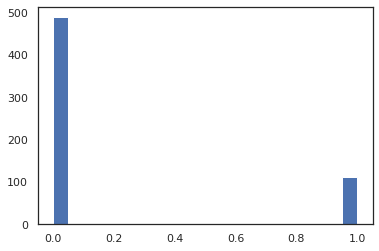

Married


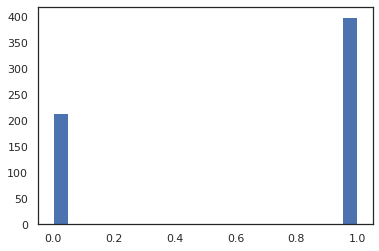

Dependents


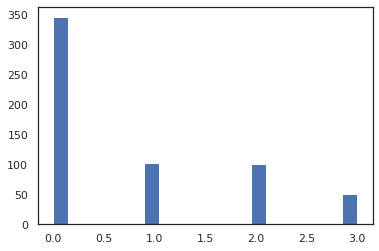

Education


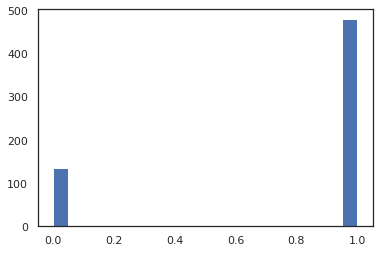

Self_Employed


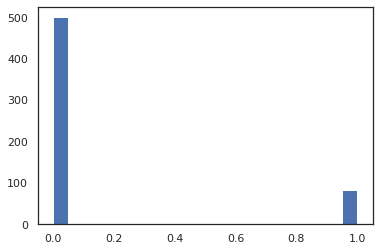

ApplicantIncome


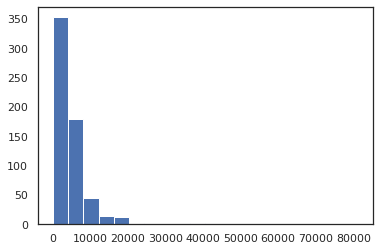

CoapplicantIncome


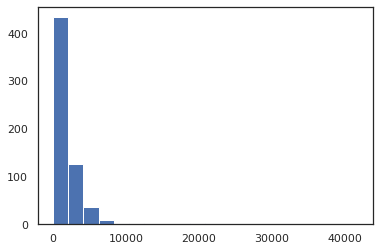

LoanAmount


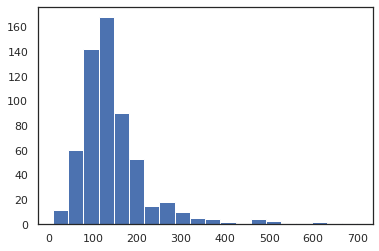

Loan_Amount_Term


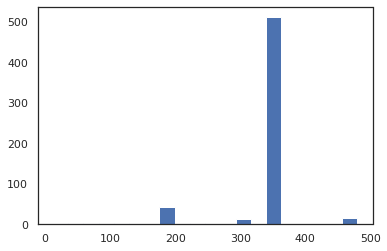

Credit_History


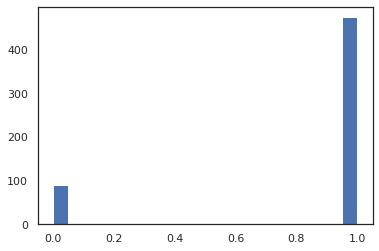

Property_Area


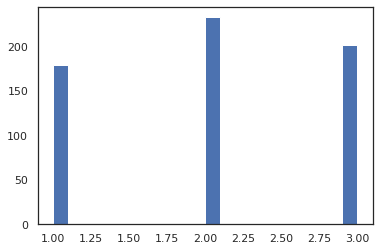

Loan_Status


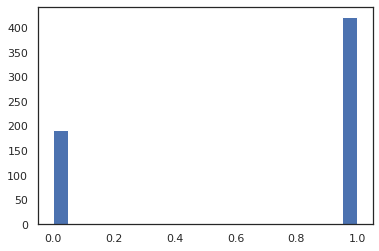

In [ ]:
for col in df.columns:
    plt.hist(df[col],bins=20)
    print(col)
    plt.show()

In [ ]:
cotas = df.describe(percentiles=[.01,.05,.95,.99]).T
cotas.reset_index(inplace=True)
cotas.rename(columns={"index":"variable"},inplace=True)

In [ ]:
cotas = cotas[["variable","1%","5%","95%","99%"]]
cotas

,variable,1%,5%,95%,99%
0,Gender,0.0,0.00,1.0,1.00
1,Married,0.0,0.00,1.0,1.00
2,Dependents,0.0,0.00,3.0,3.00
3,Education,0.0,0.00,1.0,1.00
4,Self_Employed,0.0,0.00,1.0,1.00
5,ApplicantIncome,1025.0,1897.55,14583.0,32540.41
6,CoapplicantIncome,0.0,0.00,4997.4,8895.89
7,LoanAmount,30.0,56.00,297.8,496.36
8,Loan_Amount_Term,84.0,180.00,360.0,480.00
9,Credit_History,0.0,0.00,1.0,1.00


In [ ]:
def acotar_valores(x, inf, sup):
    if (x < inf):
        return inf
    elif (x>sup):
        return sup
    else:
        return x

In [ ]:
for index, variable in enumerate(cotas.variable):
    if (variable != ['Gender','Married','Education','Self_Employed','Property_Area','Loan_Status']):
        cotas_Inf = cotas.iloc[index]["5%"]
        cotas_Sup = cotas.iloc[index]["95%"]
        print("{0} --> Limites (Inf,Sup) ({1},{2})".format(variable,cotas_Inf,cotas_Sup))
        df[variable] = df[variable].apply(lambda x: acotar_valores(x,cotas_Inf,cotas_Sup))

Gender --> Limites (Inf,Sup) (0.0,1.0)
Married --> Limites (Inf,Sup) (0.0,1.0)
Dependents --> Limites (Inf,Sup) (0.0,3.0)
Education --> Limites (Inf,Sup) (0.0,1.0)
Self_Employed --> Limites (Inf,Sup) (0.0,1.0)
ApplicantIncome --> Limites (Inf,Sup) (1897.55,14583.0)
CoapplicantIncome --> Limites (Inf,Sup) (0.0,4997.4)
LoanAmount --> Limites (Inf,Sup) (56.0,297.7999999999997)
Loan_Amount_Term --> Limites (Inf,Sup) (180.0,360.0)
Credit_History --> Limites (Inf,Sup) (0.0,1.0)
Property_Area --> Limites (Inf,Sup) (1.0,3.0)
Loan_Status --> Limites (Inf,Sup) (0.0,1.0)


Gender


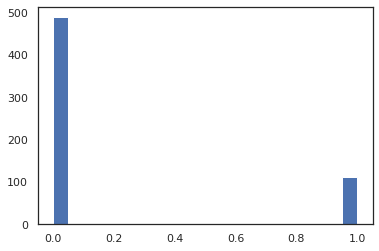

Married


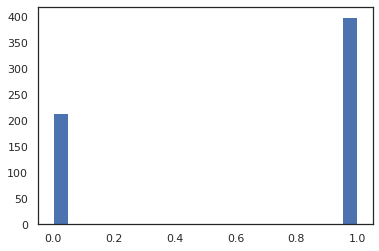

Dependents


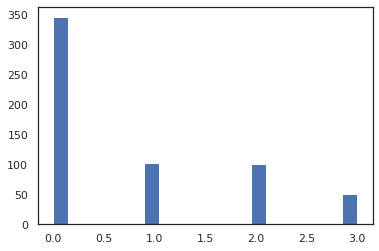

Education


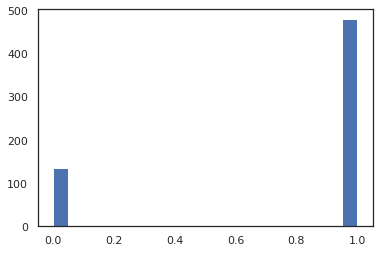

Self_Employed


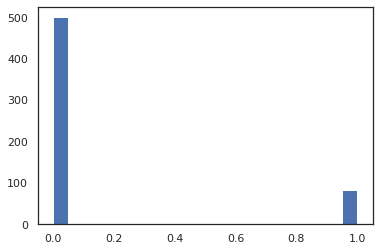

ApplicantIncome


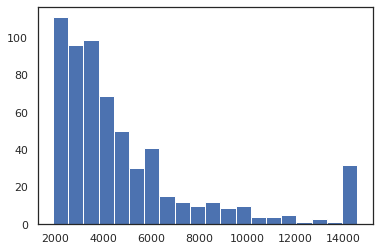

CoapplicantIncome


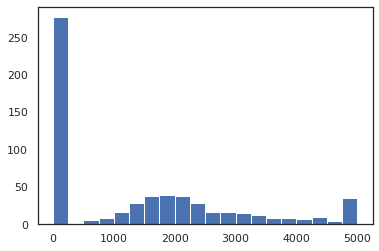

LoanAmount


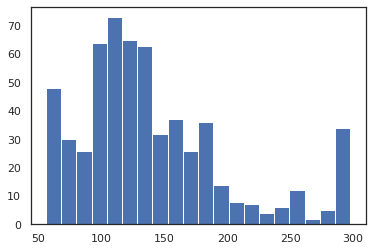

Loan_Amount_Term


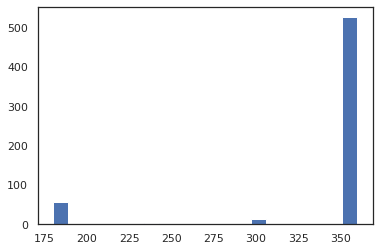

Credit_History


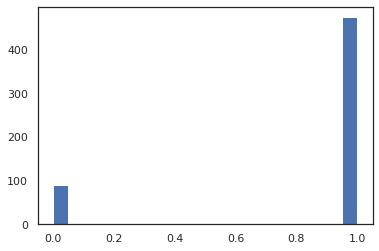

Property_Area


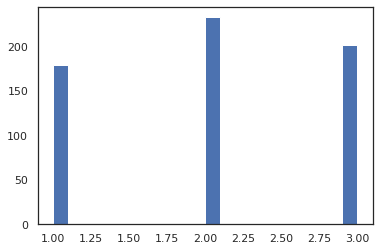

Loan_Status


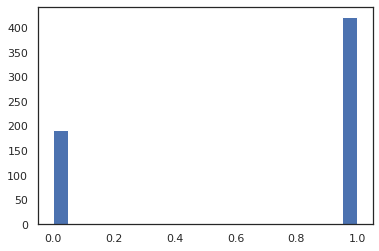

In [ ]:
for col in df.columns:
    plt.hist(df[col],bins=20)
    print(col)
    plt.show()

##Tratamiento de missings con método no paramétrico para las variables 'LoanAmount' y 'Loan_Amount_Term'

In [ ]:
#Para encontrar el kmeans óptimo
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
df_drop = df.dropna()
X = df_drop

In [ ]:
def Evaluar_K_optimo( X_train, min_cluster_test=2,max_cluster_test=5):

    Sum_of_squared_distances = []
    silhouette_avg = []

    K = range(min_cluster_test,max_cluster_test+1)

    for k in K:
        km = KMeans(n_clusters=k, random_state = 40)
        km = km.fit(X_train)
        cluster_labels = km.labels_
        Sum_of_squared_distances.append(km.inertia_)
        silhouette_avg.append(silhouette_score(X_train, cluster_labels))

    fig,ax = plt.subplots(2,1,figsize=(10,5))
    fig.tight_layout() 
    
    #Graficamos los valores de inercia para todos los experimentos de k vecinos
    ax[0].plot(K, Sum_of_squared_distances, 'gx-')
    ax[0].set_ylabel('Sum_of_squared_distances')
    ax[0].title.set_text('Elbow Curve')

    #Graficamos los valores de score de silhouette para todos los experimentos de k vecinos
    ax[1].plot(K,silhouette_avg,'bx-' )
    ax[1].set_xlabel('Values of K') 
    ax[1].set_ylabel('Silhouette score') 
    ax[1].title.set_text('Silhouette Score')
    
    plt.show()

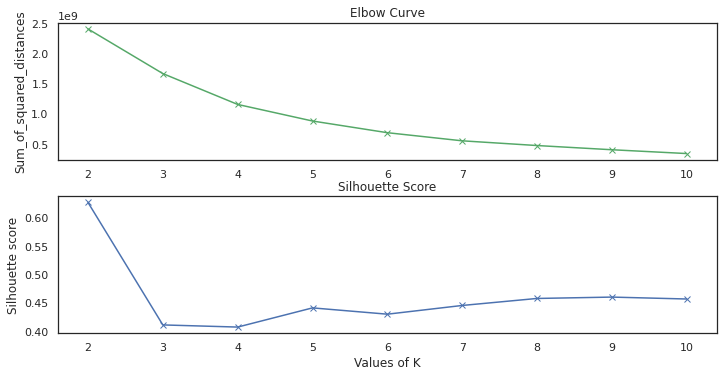

In [ ]:
Evaluar_K_optimo(X,2,10)

In [ ]:
km = KMeans(n_clusters=5, random_state = 20) #Configuramos el algoritmo con el k=5 que identificamos como "optimo"
km = km.fit(X) #Entrenamos el modelo con la data que escogimos
clusters = km.predict(X) #Devolvemos los valores calculados por el algoritmo de KMeans

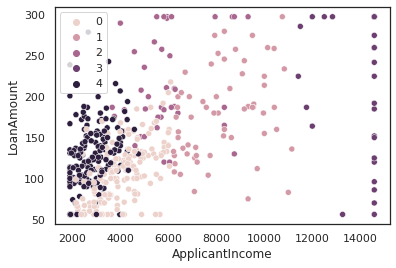

In [ ]:
sns.scatterplot( x=df_drop["ApplicantIncome"], y=df_drop["LoanAmount"], hue=clusters)
plt.show()

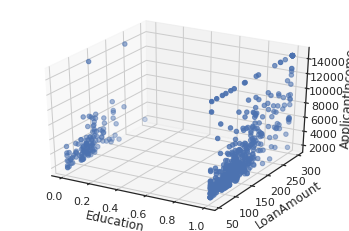

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
sns.set(style = "white")
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = df['Education']
y = df['LoanAmount']
z = df['ApplicantIncome']

ax.set_xlabel("Education")
ax.set_ylabel("LoanAmount")
ax.set_zlabel("ApplicantIncome")

ax.scatter(x, y, z)

plt.show()

In [ ]:
#Tratamos los missings con la función KNNImputer
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)

In [ ]:
df_imp=imputer.fit_transform(df)

In [ ]:
df_imp = pd.DataFrame(df_imp, columns = ['Gender','Married','Dependents','Education','Self_Employed','ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Credit_History','Property_Area','Loan_Status'])

In [ ]:
df_imp = df_imp[['LoanAmount','Loan_Amount_Term']]
df_imp.head(1)

,LoanAmount,Loan_Amount_Term
0,147.8,360.0


In [ ]:
df_KNN = df.drop(['LoanAmount','Loan_Amount_Term'], axis=1)
df = pd.concat([df_KNN, df_imp], axis=1)
df.head(1)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,Credit_History,Property_Area,Loan_Status,LoanAmount,Loan_Amount_Term
0,0.0,0.0,0.0,1,0.0,5849.0,0.0,1.0,3,1,147.8,360.0


#Tratamiento de missings para variables categóricas

In [ ]:
def FrecuenciaMissings(dataframe):
    df1=(dataframe.isnull().sum(axis=0)/dataframe.shape[0]).to_frame(name="pct missings")
    df2=dataframe.isnull().sum(axis=0).to_frame(name="numero missings")
    return pd.concat([df2,df1],axis=1)

In [ ]:
FrecuenciaMissings(df)

,numero missings,pct missings
Gender,13,0.021173
Married,3,0.004886
Dependents,15,0.024430
Education,0,0.000000
Self_Employed,32,0.052117
ApplicantIncome,0,0.000000
CoapplicantIncome,0,0.000000
Credit_History,50,0.081433
Property_Area,0,0.000000
Loan_Status,0,0.000000


In [ ]:
#Para variables categóricas 
df['Gender'] = df['Gender'].fillna(df['Gender'].mode()[0])
df['Married'] = df['Married'].fillna(df['Married'].mode()[0])
df['Self_Employed'] = df['Self_Employed'].fillna(df['Self_Employed'].mode()[0])
df['Credit_History'] = df['Credit_History'].fillna(df['Credit_History'].mode()[0])
#Para variables no categóricas
df['Dependents'] = df['Dependents'].fillna(df['Dependents'].median())
df['LoanAmount'] = df['LoanAmount'].fillna(df['LoanAmount'].median())
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].median())

In [ ]:
FrecuenciaMissings(df)

,numero missings,pct missings
Gender,0,0.0
Married,0,0.0
Dependents,0,0.0
Education,0,0.0
Self_Employed,0,0.0
ApplicantIncome,0,0.0
CoapplicantIncome,0,0.0
Credit_History,0,0.0
Property_Area,0,0.0
Loan_Status,0,0.0


#Separación de muestras

In [ ]:
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.30, random_state=40, stratify=y)

In [ ]:
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (429, 11) (429,)
Test set: (185, 11) (185,)


## Análisis multivariado

Text(0.5, 1.0, 'Correlation Heatmap')

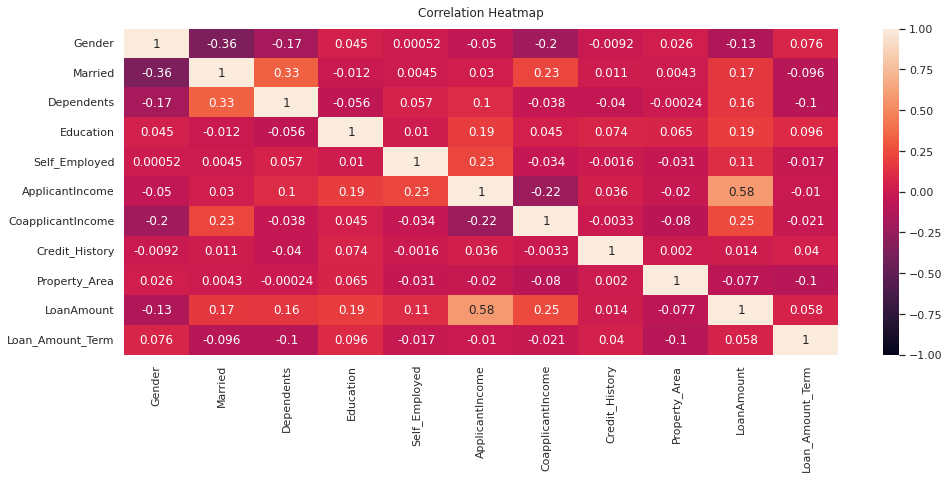

In [ ]:
plt.figure(figsize=(16, 6))

heatmap = sns.heatmap(X.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)


La matriz de correlación nos ayuda a observar asociaciones lineales de una variable respecto a otra. En este caso observamos que las variables LoanAmount y ApplicantIncome tienen una correlación alta en términos absolutos. Por lo tanto, ambas variables comparten características similares, por lo que una de ellas está de más en nuestro modelo. Ahora, comprobaremos más abajo si alguna de estas variables debería de ser eliminada o no por medio del VIF.

## Feature Engineering

In [ ]:
X_train.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'Credit_History',
       'Property_Area', 'LoanAmount', 'Loan_Amount_Term'],
      dtype='object')

In [ ]:
X_train["income_per_dependents"] = X_train["ApplicantIncome"]/(X_train["Dependents"]+1)
X_train["income_per_dProperty_Area"] = X_train["ApplicantIncome"]/(X_train["Property_Area"])
X_train['Total_Income']=X_train['ApplicantIncome']+X_train['CoapplicantIncome']
X_train['Total_Income_log'] = np.log(X_train['Total_Income'])
X_train['EMI']=X_train['LoanAmount']/X_train['Loan_Amount_Term']
X_train['Balance Income'] = X_train['Total_Income']-(X_train['EMI']*1000)

In [ ]:
X_test["income_per_dependents"] = X_test["ApplicantIncome"]/(X_test["Dependents"]+1)
X_test["income_per_dProperty_Area"] = X_test["ApplicantIncome"]/(X_test["Property_Area"])
X_test['Total_Income']=X_test['ApplicantIncome']+X_test['CoapplicantIncome']
X_test['Total_Income_log'] = np.log(X_test['Total_Income'])
X_test['EMI']=X_test['LoanAmount']/X_test['Loan_Amount_Term']
X_test['Balance Income'] = X_test['Total_Income']-(X_test['EMI']*1000)

In [ ]:
X_train=X_train.drop(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term'], axis=1)
X_test=X_test.drop(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term'], axis=1)

## Balanceo de datos

In [ ]:
y_train.value_counts()

1    295
0    134
Name: Loan_Status, dtype: int64

In [ ]:
y_train.value_counts(normalize=True)

1    0.687646
0    0.312354
Name: Loan_Status, dtype: float64

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
smote = SMOTE()
X_sm, y_sm = smote.fit_resample(X_train, y_train)

columns_X = X_train.columns
columns_y = ["Loan_Status"]

X_train_balanced = pd.DataFrame(data=X_sm,columns=columns_X)
y_train_balanced = pd.DataFrame(data=y_sm,columns=columns_y)

In [ ]:
y_train_balanced["Loan_Status"].value_counts()

1    295
0    295
Name: Loan_Status, dtype: int64

In [ ]:
X_train_bal = X_train_balanced
y_train_bal = y_train_balanced["Loan_Status"]

#Selección de variables

In [ ]:
model = RandomForestClassifier(max_depth= 8, n_estimators= 50 )
rfe = RFE(model,step=1, n_features_to_select=8)
fit = rfe.fit(X_train_bal, y_train_bal)

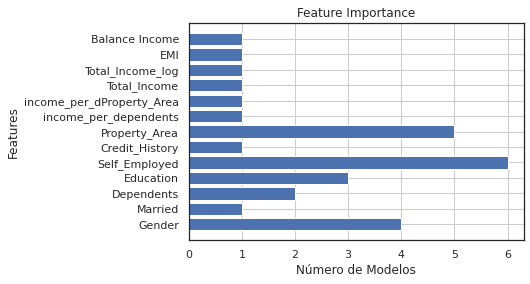

In [ ]:
pos = np.arange(len(X_train_bal.columns)) + 0.5
plt.barh(pos, fit.ranking_, align='center')
plt.title("Feature Importance")
plt.xlabel("Número de Modelos")
plt.ylabel("Features")
plt.yticks(pos, (X_train_bal.columns))
plt.grid(True)

In [ ]:
fit.support_

array([False,  True, False, False, False,  True, False,  True,  True,
        True,  True,  True,  True])

In [ ]:
features_selected = X_train.columns[fit.support_]

In [ ]:
features_selected

Index(['Married', 'Credit_History', 'income_per_dependents',
       'income_per_dProperty_Area', 'Total_Income', 'Total_Income_log', 'EMI',
       'Balance Income'],
      dtype='object')

In [ ]:
X_train_bal[features_selected].head(1)

,Married,Credit_History,income_per_dependents,income_per_dProperty_Area,Total_Income,Total_Income_log,EMI,Balance Income
0,1.0,1.0,2058.0,686.0,4192.0,8.340933,0.244444,3947.555556


## Entrenamiento y validación de modelos

In [ ]:
from sklearn.naive_bayes import GaussianNB

#Define parámetros
criterion =  'entropy'
solver = 'liblinear'
models = []
models.append(("DecisionTree",DecisionTreeClassifier(criterion=criterion, max_depth = 6)))
models.append(("LogisticRegression",LogisticRegression(C=1.0))) 
models.append(("XGBoost", XGBClassifier( colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=100 ,objective= 'binary:logistic')))
models.append(("RandomForestClassifier",RandomForestClassifier(max_depth= 10, max_features='auto', n_estimators= 200 )))
models.append(("GaussianNB",GaussianNB()))

In [ ]:
def eval_metrics(y_test,y_pred, y_prob):
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    score_f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    return (accuracy, auc, score_f1, precision, recall)

In [ ]:
df_resultados = pd.DataFrame(columns=['Modelo','AUC', 'Accuracy','Score F1', 'Precision', 'Recall'])
threshold = 0.5


_X_train = X_train_bal[features_selected]
_X_test = X_test[features_selected]
_y_train = y_train_bal
_y_test = y_test

for name,model in models:
    model_ = model.fit(_X_train, _y_train)
    #Evaluacion del modelo con datos de train

    y_pred = (model_.predict_proba(_X_test)[:,1] >= threshold ).astype(int) 
    y_prob = model_.predict_proba(_X_test)[:, 1] #probability
    (accuracy, auc, score_f1, precision, recall) = eval_metrics(_y_test,y_pred,y_prob) #metrics
    dict_test = {'Modelo': [name], 'AUC': [auc], 'Accuracy': [accuracy], 'Score F1': [score_f1], 'Precision': [precision], 'Recall': [recall]} 
    

    df_res_test = pd.DataFrame(dict_test)
    df_resultados = df_resultados.append(df_res_test, ignore_index = True)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
#Tabla de resultados
df_resultados.head()

,Modelo,AUC,Accuracy,Score F1,Precision,Recall
0,DecisionTree,0.757874,0.772973,0.845588,0.793103,0.905512
1,LogisticRegression,0.743687,0.697297,0.770492,0.803419,0.740157
2,XGBoost,0.780478,0.805405,0.866667,0.818182,0.921260
3,RandomForestClassifier,0.818898,0.821622,0.880000,0.817568,0.952756
4,GaussianNB,0.732962,0.800000,0.864469,0.808219,0.929134
